In [1]:
import os
import pickle
import numpy as np
import sys

from tqdm import tqdm
from os.path import expanduser

# add path to directory that contains web.py to system
sys.path.insert(0, os.path.join(expanduser("~"), "teachableDFS"))
from web import FootballBoxscore, unique_game_links
from config import CACHE_DIRECTORY

## Parameters


In [2]:
seasons = [2018, 2019, 2020, 2021]

## Web

In [3]:
all_scores = {}
for season in seasons:
    links = unique_game_links(season)
    all_scores[season] = [FootballBoxscore("https://www.pro-football-reference.com/" + link) for link in links]
    
    for fbs in tqdm(all_scores[season]):
        try: 
            fbs.full_scrape()
        except AttributeError:
            break

    # Cache the results
    if not os.path.exists(CACHE_DIRECTORY):
        os.makedirs(CACHE_DIRECTORY)
    
    data_path = os.path.join(CACHE_DIRECTORY, f"{season}_box.pkl")
    pickle.dump(all_scores[season], open(data_path,'wb'))

 98%|█████████▊| 48/49 [00:27<00:00,  1.72it/s]


## Data

In [4]:
from data import ScoreTable, OffenseTable, DefenseTeamTable, OffenseTeamTable
from data import AdvancedPassingTable, AdvancedReceivingTable, AdvancedRushingTable 

In [5]:
# Feature space classes will get references to these, so make sure they are built
for season in seasons:
    complete_boxscores = [box for box in all_scores[season] if "adv_player_passing" in box.__dict__.keys()]
    score_table        = ScoreTable(refresh=True, season=season, boxscores=complete_boxscores)
    offense_table      = OffenseTable(refresh=True, season=season, boxscores=complete_boxscores)
    adv_passing_table  = AdvancedPassingTable(refresh=True, season=season, boxscores=complete_boxscores)
    adv_recv_table     = AdvancedReceivingTable(refresh=True, season=season, boxscores=complete_boxscores)
    adv_rush_table     = AdvancedRushingTable(refresh=True, season=season, boxscores=complete_boxscores)
    defense_table      = DefenseTeamTable(refresh=True, season=season, boxscores=complete_boxscores)
    offense_team_table = OffenseTeamTable(refresh=True, season=season, boxscores=complete_boxscores)

100%|██████████| 48/48 [00:00<00:00, 157.09it/s]


### Model

In [6]:
from model import QuarterbackFeatureSpaceTable, PositionPlayerFeatureSpaceTable, DefenseFeatureSpaceTable

In [7]:
qb_featurespace    = QuarterbackFeatureSpaceTable(seasons=seasons)
pl_featurespace    = PositionPlayerFeatureSpaceTable(seasons=seasons)
df_featurespace    = DefenseFeatureSpaceTable(seasons=seasons)

1588it [00:23, 68.54it/s]
13650it [04:01, 56.61it/s]
1546it [00:15, 100.27it/s]


### Sim

In [8]:
from sim import PayoutTable, BacktestLinksTable, HistoricalSalaryTable, BacktestStandingsTable
from sim import BacktestPlayerPerformanceTable, BacktestPredictionsTable

In [9]:
seasons = [2018, 2019, 2020]
payoutTable           = PayoutTable(refresh=True)
backtestLinks         = BacktestLinksTable(refresh=True)
historicalSalary      = HistoricalSalaryTable(refresh=True, seasons=seasons)
historicalStandings   = BacktestStandingsTable(refresh=True)
historicalPerformance = BacktestPlayerPerformanceTable(refresh=True, seasons=seasons)
backtestPredictions   = BacktestPredictionsTable(refresh=True, seasons=seasons)

100%|██████████| 45/45 [00:17<00:00,  2.60it/s]
10it [00:09,  1.04it/s]
100%|██████████| 45/45 [00:12<00:00,  3.64it/s]
10it [00:08,  1.16it/s]
100%|██████████| 45/45 [00:12<00:00,  3.58it/s]
10it [00:08,  1.16it/s]
45it [00:00, 68.36it/s]
380it [00:06, 58.45it/s]
26it [00:00, 97.98it/s]
43it [00:00, 69.85it/s]
380it [00:06, 57.81it/s]
26it [00:00, 99.84it/s]
36it [00:00, 70.48it/s]
322it [00:05, 58.06it/s]
22it [00:00, 98.32it/s]
44it [00:00, 70.44it/s]
344it [00:05, 58.20it/s]
24it [00:00, 99.42it/s]
41it [00:00, 70.10it/s]
308it [00:05, 57.95it/s]
22it [00:00, 96.98it/s]
43it [00:00, 68.09it/s]
338it [00:05, 57.30it/s]
24it [00:00, 98.94it/s]
42it [00:00, 69.44it/s]
346it [00:06, 57.36it/s]
22it [00:00, 96.97it/s]
40it [00:00, 70.02it/s]
308it [00:05, 58.03it/s]
22it [00:00, 97.30it/s] 
47it [00:00, 68.42it/s]
349it [00:06, 57.48it/s]
22it [00:00, 96.55it/s]
41it [00:00, 67.89it/s]
313it [00:05, 57.08it/s]
22it [00:00, 96.13it/s]


### Double Up Backtest

In [10]:
from sim import DoubleupStandingsTable

In [11]:
historicalPerformance = BacktestPlayerPerformanceTable(refresh=False, seasons=seasons)
backtestPredictions   = BacktestPredictionsTable(refresh=False, seasons=seasons)
doubleupStandings     = DoubleupStandingsTable(refresh=True)

10it [00:08,  1.19it/s]


In [12]:
perf = historicalPerformance.table.copy()
pred = backtestPredictions.table.reset_index().rename(columns={'level_0':'name', 
                                                               'level_1':'week', \
                                                               'level_2':'year', 
                                                                0:'pred'}).copy()
btTable = perf.join(pred.set_index(['name','week','year']), on=['name','week','year'])
btTable = btTable.dropna(subset=['DK salary'])
btTable = btTable[~((btTable.FPTS == 0) & (btTable['Roster Position'] != "DST"))] # Don't start anyone thats out

In [13]:
import numpy as np
from tqdm import tqdm
from sim import run_doubleup_backtest

In [14]:
out = {}
for wk, results in tqdm(btTable.groupby('week')):
    if wk < 4.0: 
        continue
    out[wk] = {}
    for num_teams_to_stack in [1,2,3]:
        for num_players_in_stack in [2,3]:
            x = np.array([num_teams_to_stack, num_players_in_stack])
            key = ".".join([str(i) for i in x]) 
            out[wk][key] = run_doubleup_backtest(x,results, doubleupStandings.table.copy())
            print(wk, key, out[wk][key])

  0%|          | 0/10 [00:00<?, ?it/s]

4 1.2 400.0
4 1.3 400.0
4 2.2 320.0
4 2.3 320.0
4 3.2 280.0


 30%|███       | 3/10 [00:08<00:18,  2.70s/it]

4 3.3 320.0
5 1.2 0.0
5 1.3 -280.0
5 2.2 -240.0
5 2.3 -360.0
5 3.2 -280.0


 40%|████      | 4/10 [00:15<00:25,  4.17s/it]

5 3.3 -120.0
6 1.2 -400.0
6 1.3 -40.0
6 2.2 -160.0
6 2.3 200.0
6 3.2 -160.0


 50%|█████     | 5/10 [00:23<00:25,  5.18s/it]

6 3.3 0.0
7 1.2 80.0
7 1.3 120.0
7 2.2 280.0
7 2.3 0.0
7 3.2 160.0


 60%|██████    | 6/10 [00:31<00:23,  5.96s/it]

7 3.3 160.0
8 1.2 160.0
8 1.3 200.0
8 2.2 280.0
8 2.3 -120.0
8 3.2 200.0


 70%|███████   | 7/10 [00:39<00:19,  6.59s/it]

8 3.3 40.0
9 1.2 360.0
9 1.3 320.0
9 2.2 400.0
9 2.3 240.0
9 3.2 160.0


 80%|████████  | 8/10 [00:47<00:14,  7.02s/it]

9 3.3 200.0
10 1.2 120.0
10 1.3 160.0
10 2.2 40.0
10 2.3 360.0
10 3.2 40.0


 90%|█████████ | 9/10 [00:54<00:07,  7.17s/it]

10 3.3 80.0
11 1.2 0.0
11 1.3 400.0
11 2.2 200.0
11 2.3 80.0
11 3.2 80.0


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]

11 3.3 120.0


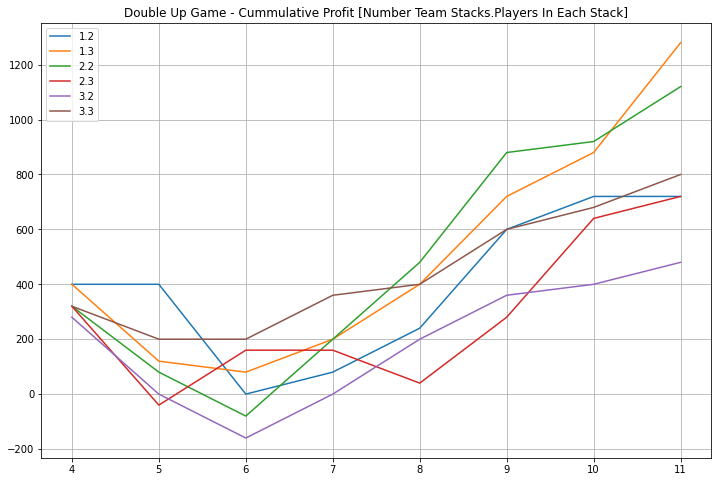

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(out).T.cumsum().plot(figsize=(12,8), title='Double Up Game - Cummulative Profit [Number Team Stacks.Players In Each Stack]')
plt.grid(True)